## How much tracer is there on the shelf?

This notebook explores the effects of changing the initial tracer profile on the total amount of tracer (mass) on the shelf at a certain time and place.

In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 


In [3]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

In [4]:
#Exp
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGridOut = Dataset(CGrid)

BARrun01 = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/stateGlob.nc'
StateOut01 = Dataset(BARrun01)

TRArun01 = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'
PtracersOut01 = Dataset(TRArun01)



In [5]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

rc = CGridOut.variables['RC']
xc = rout.getField(CGrid, 'XC') # x coords tracer cells
yc = rout.getField(CGrid, 'YC') # y coords tracer cells

drF = CGridOut.variables['drF'] # vertical distance between faces
dxG = rout.getField(CGrid,'dxG')

MaskCan = rout.getMask(CGrid,'HFacC') 
hFacCCan = rout.getField(CGrid,'HFacC') 
rACan = rout.getField(CGrid,'rA') 
drFCan= CGridOut.variables['drF']


In [6]:
print(rc[:])

[   -2.5    -7.5   -12.5   -17.5   -22.5   -27.5   -32.5   -37.5   -42.5
   -47.5   -52.5   -57.5   -62.5   -67.5   -72.5   -77.5   -82.5   -87.5
   -92.5   -97.5  -102.5  -107.5  -112.5  -117.5  -122.5  -127.5  -132.5
  -137.5  -142.5  -147.5  -152.5  -157.5  -162.5  -167.5  -175.   -185.
  -195.   -205.   -215.   -225.   -235.   -245.   -255.   -270.   -290.
  -310.   -330.   -350.   -370.   -390.   -410.   -430.   -450.   -470.
  -490.   -510.   -530.   -550.   -570.   -590.   -610.   -630.   -650.
  -670.   -690.   -710.   -730.   -750.   -770.   -790.   -810.   -830.
  -850.   -870.   -890.   -910.   -930.   -950.   -970.   -990.  -1010.
 -1030.  -1050.  -1070.  -1090.  -1110.  -1130.  -1150.  -1170.  -1190. ]


In [7]:
# Load tracers 
Tr1 = rout.getField(TRArun01,'Tr01')
Tr2 = rout.getField(TRArun01,'Tr02') 
Tr3 = rout.getField(TRArun01,'Tr03') 
Tr4 = rout.getField(TRArun01,'Tr04') 


In [8]:
Tr5 = rout.getField(TRArun01,'Tr05') 
Tr6 = rout.getField(TRArun01,'Tr06') 
Tr7 = rout.getField(TRArun01,'Tr07') 
Tr8 = rout.getField(TRArun01,'Tr08') 


### How much water with concentration higher than a limit is there on the shelf at each time? How much tracer mass?

In [9]:
def HowMuchWaterX(Tr,MaskC,nzlim,rA,hFacC,drF,yin,zfin):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [:,:30,227:,:] at every time output.
    Total_Tracer =  Array with the mass of tracer (Mol) at each x-position over the shelf [:,:30,227:,:] at every time output.
          Total mass of tracer at xx on the shelf.
                                                
    -----------------------------------------------------------------------------------------------------------------------
    '''
    mask_expand = np.expand_dims(MaskC,0)
    mask_expand = mask_expand + np.zeros(Tr.shape)

    TrMask0=np.ma.array(Tr[0,:,:,:],mask=mask_expand[0,:,:,:])
        
    trlim = TrMask0[nzlim,50,180]
    
    hFacCSwap = np.swapaxes(hFacC, 0, 2)
    
    print('tracer limit is: ',trlim)
    
    TrMask=np.ma.array(Tr,mask=mask_expand)
    
    WaterX = 0
    
    # mask cells with tracer concentration < trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
    HighConc_Mask = HighConc_Masked.mask
    
    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[yin:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
    ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    VolWaterHighConc = np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1)
    
    
    
    #Get total mass of tracer on shelf
    Total_Tracer = np.ma.sum(np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1),axis=1) 
    # 1 m^3 = 1000 l
    
    return (VolWaterHighConc, Total_Tracer)

### Calculate volume on shelf of high tracer concentration water and tracer mass. 

In [10]:


(WatTr1, TrMassTr1) = HowMuchWaterX(Tr1,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr2, TrMassTr2) = HowMuchWaterX(Tr2,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr3, TrMassTr3) = HowMuchWaterX(Tr3,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr4, TrMassTr4) = HowMuchWaterX(Tr4,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr5, TrMassTr5) = HowMuchWaterX(Tr5,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr6, TrMassTr6) = HowMuchWaterX(Tr6,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr7, TrMassTr7) = HowMuchWaterX(Tr7,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
(WatTr8, TrMassTr8) = HowMuchWaterX(Tr8,MaskCan,30,rACan,hFacCCan,drFCan,227,30) 
      
    
   

('tracer limit is: ', 32.251045)
('tracer limit is: ', 33.898914)
('tracer limit is: ', 103.13976)
('tracer limit is: ', 32.763577)
('tracer limit is: ', 47.862217)
('tracer limit is: ', 2.2521822)
('tracer limit is: ', 27.700876)
('tracer limit is: ', 19.381783)


In [11]:
print(rc[30])

-152.5


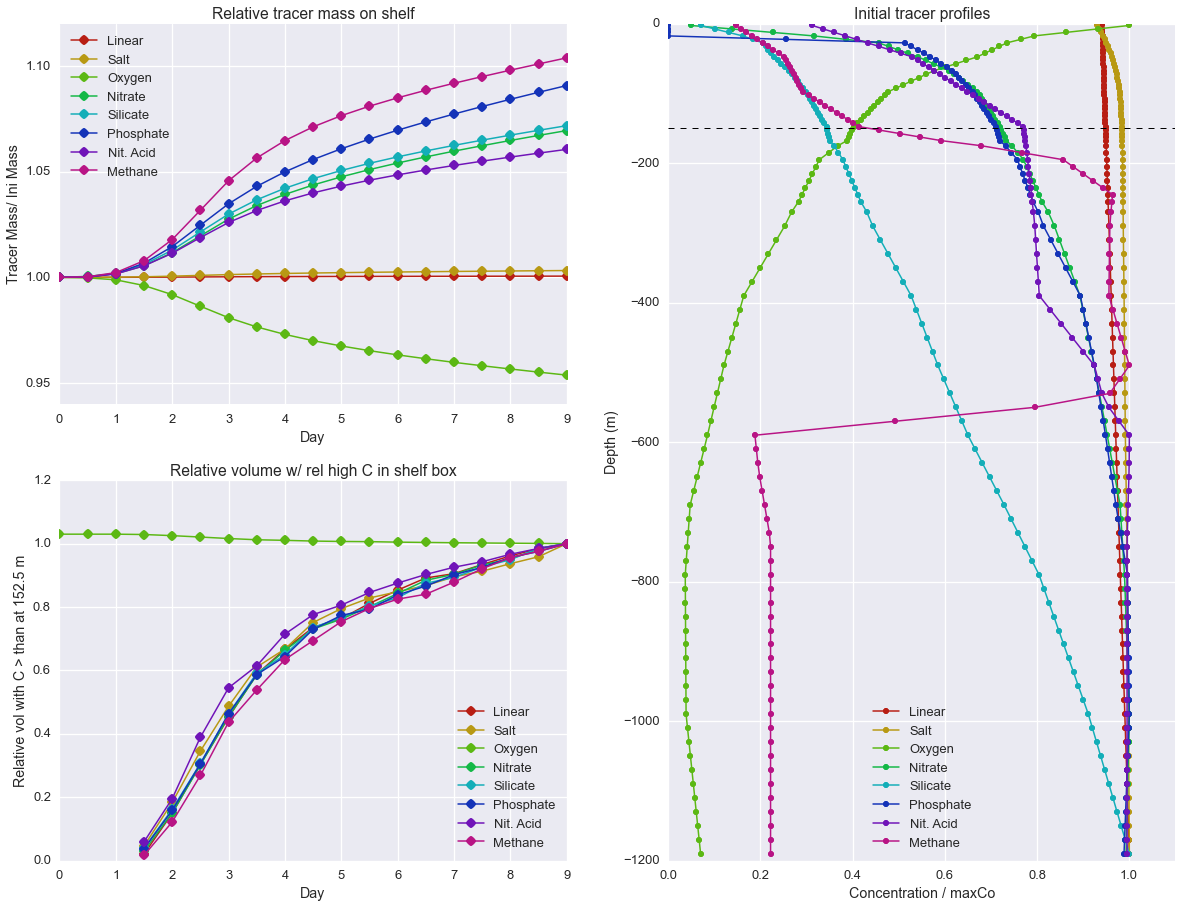

In [12]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    ax1 = plt.subplot(2,2,1)

    line1 = ax1.plot(times/2.0, TrMassTr1/TrMassTr1[0],'o-', label='Linear')
    line2 = ax1.plot(times/2.0, TrMassTr2/TrMassTr2[0],'o-', label='Salt')
    line3 = ax1.plot(times/2.0, TrMassTr3/TrMassTr3[0],'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, TrMassTr4/TrMassTr4[0],'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, TrMassTr5/TrMassTr5[0],'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, TrMassTr6/TrMassTr6[0],'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, TrMassTr7/TrMassTr7[0],'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, TrMassTr8/TrMassTr8[0],'o-', label='Methane')

    plt.ylabel('Tracer Mass/ Ini Mass ')
    plt.xlabel('Day')
    plt.title('Relative tracer mass on shelf')
with sns.hls_palette(8, l=.4, s=.8):
    ax2 = plt.subplot(2,2,3)

    line1 = ax2.plot(times/2.0, WatTr1/WatTr1[len(WatTr1)-1],'o-',label='Linear')
    line2 = ax2.plot(times/2.0, WatTr2/WatTr2[len(WatTr2)-1],'o-', label='Salt')
    line3 = ax2.plot(times/2.0, WatTr3/WatTr3[len(WatTr3)-1],'o-', label='Oxygen')
    line4 = ax2.plot(times/2.0, WatTr4/WatTr4[len(WatTr4)-1],'o-', label='Nitrate')
    line5 = ax2.plot(times/2.0, WatTr5/WatTr5[len(WatTr5)-1],'o-', label='Silicate')
    line6 = ax2.plot(times/2.0, WatTr6/WatTr6[len(WatTr6)-1],'o-', label='Phosphate')
    line7 = ax2.plot(times/2.0, WatTr7/WatTr7[len(WatTr7)-1],'o-', label='Nit. Acid')
    line8 = ax2.plot(times/2.0, WatTr8/WatTr8[len(WatTr8)-1],'o-', label='Methane')
    
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 152.5 m')
    plt.xlabel('Day')
 
with sns.hls_palette(8, l=.4, s=.8):
    ax3 = plt.subplot(2,2,(2,4))

    line1 = ax3.plot(Tr1[0,:,50,180]/np.max(Tr1[0,:,50,180]),rc[:],'o-',markersize = 6, label='Linear')
    line2 = ax3.plot(Tr2[0,:,50,180]/np.max(Tr2[0,:,50,180]),rc[:],'o-',markersize = 6, label='Salt')
    line3 = ax3.plot(Tr3[0,:,50,180]/np.max(Tr3[0,:,50,180]),rc[:],'o-',markersize = 6, label='Oxygen')
    line4 = ax3.plot(Tr4[0,:,50,180]/np.max(Tr4[0,:,50,180]),rc[:],'o-',markersize = 6, label='Nitrate')
    line5 = ax3.plot(Tr5[0,:,50,180]/np.max(Tr5[0,:,50,180]),rc[:],'o-',markersize = 6, label='Silicate')
    line6 = ax3.plot(Tr6[0,:,50,180]/np.max(Tr6[0,:,50,180]),rc[:],'o-',markersize = 6, label='Phosphate')
    line7 = ax3.plot(Tr7[0,:,50,180]/np.max(Tr7[0,:,50,180]),rc[:],'o-',markersize = 6, label='Nit. Acid')
    line8 = ax3.plot(Tr8[0,:,50,180]/np.max(Tr8[0,:,50,180]),rc[:],'o-',markersize = 6, label='Methane')
    
    ax3.set_xlim(0,1.1)
    plt.title('Initial tracer profiles')
    plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / maxCo')
 
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


### Water deeper than 162.5 m

In [13]:
(WatTr1b, TrMassTr1b) = HowMuchWaterX(Tr1,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr2b, TrMassTr2b) = HowMuchWaterX(Tr2,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr3b, TrMassTr3b) = HowMuchWaterX(Tr3,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr4b, TrMassTr4b) = HowMuchWaterX(Tr4,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr5b, TrMassTr5b) = HowMuchWaterX(Tr5,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr6b, TrMassTr6b) = HowMuchWaterX(Tr6,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr7b, TrMassTr7b) = HowMuchWaterX(Tr7,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
(WatTr8b, TrMassTr8b) = HowMuchWaterX(Tr8,MaskCan,32,rACan,hFacCCan,drFCan,227,30) 
print(rc[32])


('tracer limit is: ', 32.267784)
('tracer limit is: ', 33.908943)
('tracer limit is: ', 101.2778)
('tracer limit is: ', 33.074894)
('tracer limit is: ', 48.334621)
('tracer limit is: ', 2.2650213)
('tracer limit is: ', 27.7679)
('tracer limit is: ', 23.136126)
-162.5


In [14]:
(WatTr1c, TrMassTr1c) = HowMuchWaterX(Tr1,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr2c, TrMassTr2c) = HowMuchWaterX(Tr2,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr3c, TrMassTr3c) = HowMuchWaterX(Tr3,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr4c, TrMassTr4c) = HowMuchWaterX(Tr4,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr5c, TrMassTr5c) = HowMuchWaterX(Tr5,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr6c, TrMassTr6c) = HowMuchWaterX(Tr6,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr7c, TrMassTr7c) = HowMuchWaterX(Tr7,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
(WatTr8c, TrMassTr8c) = HowMuchWaterX(Tr8,MaskCan,34,rACan,hFacCCan,drFCan,227,30) 
print(rc[34])


('tracer limit is: ', 32.292889)
('tracer limit is: ', 33.921738)
('tracer limit is: ', 95.148811)
('tracer limit is: ', 33.797066)
('tracer limit is: ', 49.895245)
('tracer limit is: ', 2.3121016)
('tracer limit is: ', 27.868439)
('tracer limit is: ', 28.767641)
-175.0


In [32]:
(WatTr1d, TrMassTr1d) = HowMuchWaterX(Tr1,MaskCan,35,rACan,hFacCCan,drFCan,227,30) 
(WatTr2d, TrMassTr2d) = HowMuchWaterX(Tr2,MaskCan,35,rACan,hFacCCan,drFCan,227,30) 
(WatTr3d, TrMassTr3d) = HowMuchWaterX(Tr3,MaskCan,35,rACan,hFacCCan,drFCan,227,30) 
(WatTr4d, TrMassTr4d) = HowMuchWaterX(Tr4,MaskCan,35,rACan,hFacCCan,drFCan,227,30) 
(WatTr5d, TrMassTr5d) = HowMuchWaterX(Tr5,MaskCan,35,rACan,hFacCCan,drFCan,227,30) 
(WatTr6d, TrMassTr6d) = HowMuchWaterX(Tr6,MaskCan,35,rACan,hFacCCan,drFCan,227,30) 
(WatTr7d, TrMassTr7d) = HowMuchWaterX(Tr7,MaskCan,35,rACan,hFacCCan,drFCan,227,30) 
(WatTr8d, TrMassTr8d) = HowMuchWaterX(Tr8,MaskCan,35,rACan,hFacCCan,drFCan,227,30) 
print(rc[35])

('tracer limit is: ', 32.309624)
('tracer limit is: ', 33.929512)
('tracer limit is: ', 89.950798)
('tracer limit is: ', 34.363579)
('tracer limit is: ', 51.219666)
('tracer limit is: ', 2.3527625)
('tracer limit is: ', 27.935465)
('tracer limit is: ', 32.521984)
-185.0


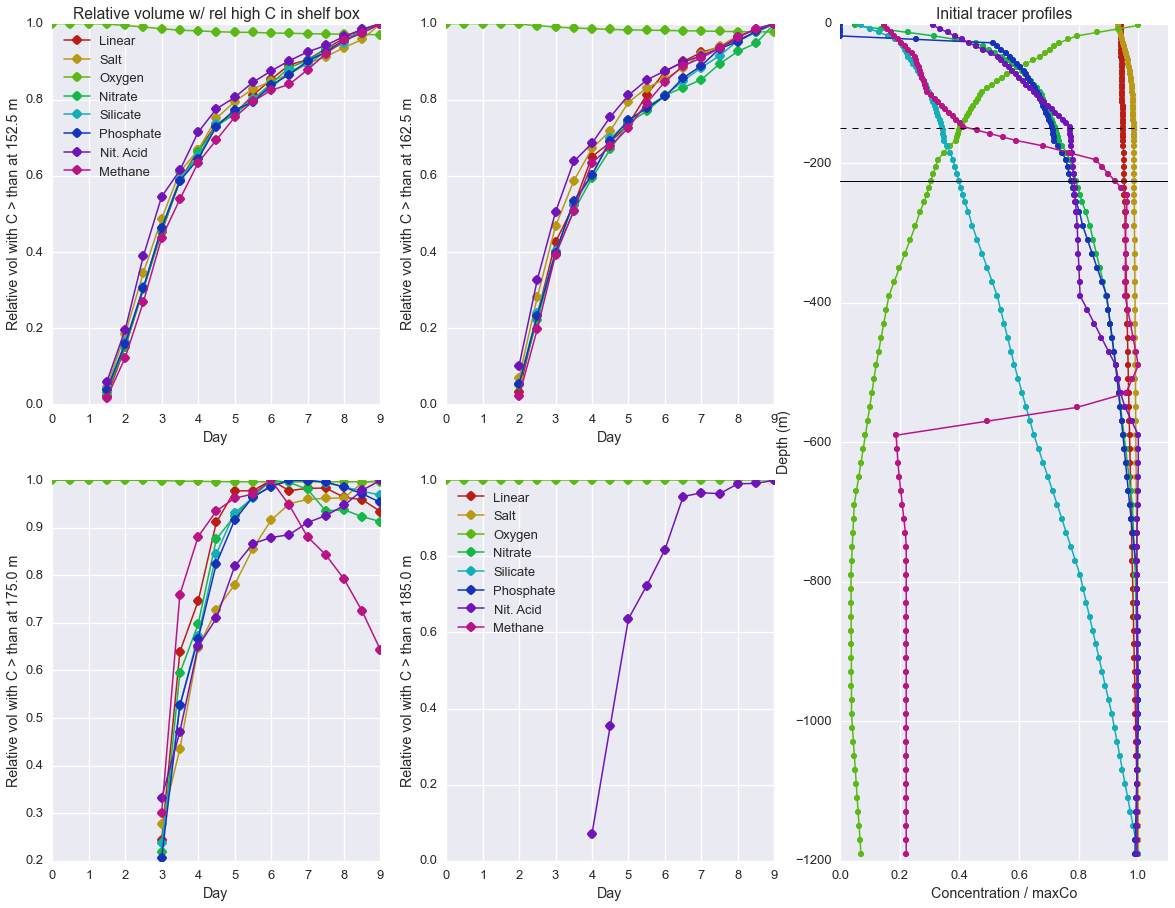

In [33]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    ax1 = plt.subplot(2,3,1)

    line1 = ax1.plot(times/2.0, WatTr1/np.max(WatTr1),'o-',label='Linear')
    line2 = ax1.plot(times/2.0, WatTr2/np.max(WatTr2),'o-', label='Salt')
    line3 = ax1.plot(times/2.0, WatTr3/np.max(WatTr3),'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, WatTr4/np.max(WatTr4),'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, WatTr5/np.max(WatTr5),'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, WatTr6/np.max(WatTr6),'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, WatTr7/np.max(WatTr7),'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, WatTr8/np.max(WatTr8),'o-', label='Methane')
    
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 152.5 m')
    plt.xlabel('Day')

with sns.hls_palette(8, l=.4, s=.8):
    ax2 = plt.subplot(2,3,2)

    line1 = ax2.plot(times/2.0, WatTr1b/np.max(WatTr1b),'o-',label='Linear')
    line2 = ax2.plot(times/2.0, WatTr2b/np.max(WatTr2b),'o-', label='Salt')
    line3 = ax2.plot(times/2.0, WatTr3b/np.max(WatTr3b),'o-', label='Oxygen')
    line4 = ax2.plot(times/2.0, WatTr4b/np.max(WatTr4b),'o-', label='Nitrate')
    line5 = ax2.plot(times/2.0, WatTr5b/np.max(WatTr5b),'o-', label='Silicate')
    line6 = ax2.plot(times/2.0, WatTr6b/np.max(WatTr6b),'o-', label='Phosphate')
    line7 = ax2.plot(times/2.0, WatTr7b/np.max(WatTr7b),'o-', label='Nit. Acid')
    line8 = ax2.plot(times/2.0, WatTr8b/np.max(WatTr8b),'o-', label='Methane')
    
    #plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 162.5 m')
    plt.xlabel('Day')
 
with sns.hls_palette(8, l=.4, s=.8):
    ax3 = plt.subplot(2,3,4)

    line1 = ax3.plot(times/2.0, WatTr1c/np.max(WatTr1c),'o-',label='Linear')
    line2 = ax3.plot(times/2.0, WatTr2c/np.max(WatTr2c),'o-', label='Salt')
    line3 = ax3.plot(times/2.0, WatTr3c/np.max(WatTr3c),'o-', label='Oxygen')
    line4 = ax3.plot(times/2.0, WatTr4c/np.max(WatTr4c),'o-', label='Nitrate')
    line5 = ax3.plot(times/2.0, WatTr5c/np.max(WatTr5c),'o-', label='Silicate')
    line6 = ax3.plot(times/2.0, WatTr6c/np.max(WatTr6c),'o-', label='Phosphate')
    line7 = ax3.plot(times/2.0, WatTr7c/np.max(WatTr7c),'o-', label='Nit. Acid')
    line8 = ax3.plot(times/2.0, WatTr8c/np.max(WatTr8c),'o-', label='Methane')
    
    #plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 175.0 m')
    plt.xlabel('Day')
    
with sns.hls_palette(8, l=.4, s=.8):
    ax4 = plt.subplot(2,3,5)

    line1 = ax4.plot(times/2.0, WatTr1d/np.max(WatTr1d),'o-',label='Linear')
    line2 = ax4.plot(times/2.0, WatTr2d/np.max(WatTr2d),'o-', label='Salt')
    line3 = ax4.plot(times/2.0, WatTr3d/np.max(WatTr3d),'o-', label='Oxygen')
    line4 = ax4.plot(times/2.0, WatTr4d/np.max(WatTr4d),'o-', label='Nitrate')
    line5 = ax4.plot(times/2.0, WatTr5d/np.max(WatTr5d),'o-', label='Silicate')
    line6 = ax4.plot(times/2.0, WatTr6d/np.max(WatTr6d),'o-', label='Phosphate')
    line7 = ax4.plot(times/2.0, WatTr7d/np.max(WatTr7d),'o-', label='Nit. Acid')
    line8 = ax4.plot(times/2.0, WatTr8d/np.max(WatTr8d),'o-', label='Methane')
    
    #plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 185.0 m')
    plt.xlabel('Day')

with sns.hls_palette(8, l=.4, s=.8):
    ax5 = plt.subplot(2,3,(3,6))
    
    line1 = ax5.plot(Tr1[0,:,50,180]/np.max(Tr1[0,:,50,180]),rc[:],'o-',markersize = 6, label='Linear')
    line2 = ax5.plot(Tr2[0,:,50,180]/np.max(Tr2[0,:,50,180]),rc[:],'o-',markersize = 6, label='Salt')
    line3 = ax5.plot(Tr3[0,:,50,180]/np.max(Tr3[0,:,50,180]),rc[:],'o-',markersize = 6, label='Oxygen')
    line4 = ax5.plot(Tr4[0,:,50,180]/np.max(Tr4[0,:,50,180]),rc[:],'o-',markersize = 6, label='Nitrate')
    line5 = ax5.plot(Tr5[0,:,50,180]/np.max(Tr5[0,:,50,180]),rc[:],'o-',markersize = 6, label='Silicate')
    line6 = ax5.plot(Tr6[0,:,50,180]/np.max(Tr6[0,:,50,180]),rc[:],'o-',markersize = 6, label='Phosphate')
    line7 = ax5.plot(Tr7[0,:,50,180]/np.max(Tr7[0,:,50,180]),rc[:],'o-',markersize = 6, label='Nit. Acid')
    line8 = ax5.plot(Tr8[0,:,50,180]/np.max(Tr8[0,:,50,180]),rc[:],'o-',markersize = 6, label='Methane')
    
     
    ax5.set_xlim(0,1.1)
    plt.title('Initial tracer profiles')
    plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / maxCo')
    
    
#plt.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
#handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, labels,loc=0)

handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


The deepest water I could find on the shelf at some time during the simulation comes from 235 m for methane (rc[40]) and from 225 m for the other tracers (rc[39]). The max volume of high-concentration water seems to occur earlier in the simulation for higher (deeper) concentrations. Does that give a mixing/diffusion timescale? time of max will occur at different times for different concentration thresholds, most likely the higher the concentration the smaller the day of occurence. 


There is another timescale: It takes water initially at 225 m about 3 days to get to the shelf, and water initially at 175 m about 1.5 days and water at 165 m about 1 day ...


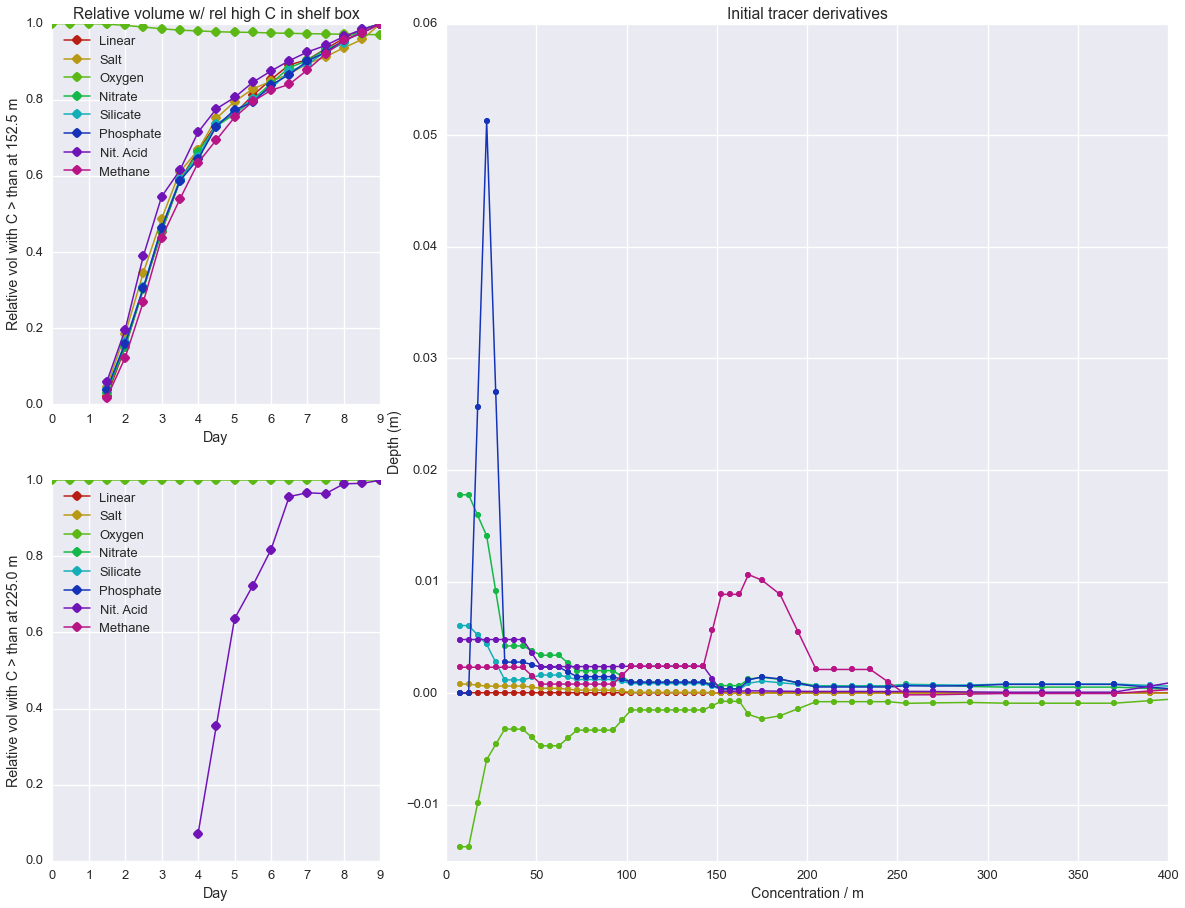

In [34]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

NormDerTr1 = ((Tr1[0,2:,50,180]-Tr1[0,:-2,50,180])/np.max(Tr1[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr2 = ((Tr2[0,2:,50,180]-Tr2[0,:-2,50,180])/np.max(Tr2[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr3 = ((Tr3[0,2:,50,180]-Tr3[0,:-2,50,180])/np.max(Tr3[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr4 = ((Tr4[0,2:,50,180]-Tr4[0,:-2,50,180])/np.max(Tr4[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr5 = ((Tr5[0,2:,50,180]-Tr5[0,:-2,50,180])/np.max(Tr5[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr6 = ((Tr6[0,2:,50,180]-Tr6[0,:-2,50,180])/np.max(Tr6[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr7 = ((Tr7[0,2:,50,180]-Tr7[0,:-2,50,180])/np.max(Tr7[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr8 = ((Tr8[0,2:,50,180]-Tr8[0,:-2,50,180])/np.max(Tr8[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))



#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    #ax1 = plt.subplot(2,3,1)
    ax1 = plt.subplot2grid((2,3), (0,0))

    line1 = ax1.plot(times/2.0, WatTr1/np.max(WatTr1),'o-',label='Linear')
    line2 = ax1.plot(times/2.0, WatTr2/np.max(WatTr2),'o-', label='Salt')
    line3 = ax1.plot(times/2.0, WatTr3/np.max(WatTr3),'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, WatTr4/np.max(WatTr4),'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, WatTr5/np.max(WatTr5),'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, WatTr6/np.max(WatTr6),'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, WatTr7/np.max(WatTr7),'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, WatTr8/np.max(WatTr8),'o-', label='Methane')
    
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 152.5 m')
    plt.xlabel('Day')


with sns.hls_palette(8, l=.4, s=.8):
    #ax4 = plt.subplot(2,3,4)
    ax4 = plt.subplot2grid((2,3), (1,0))
    line1 = ax4.plot(times/2.0, WatTr1d/np.max(WatTr1d),'o-',label='Linear')
    line2 = ax4.plot(times/2.0, WatTr2d/np.max(WatTr2d),'o-', label='Salt')
    line3 = ax4.plot(times/2.0, WatTr3d/np.max(WatTr3d),'o-', label='Oxygen')
    line4 = ax4.plot(times/2.0, WatTr4d/np.max(WatTr4d),'o-', label='Nitrate')
    line5 = ax4.plot(times/2.0, WatTr5d/np.max(WatTr5d),'o-', label='Silicate')
    line6 = ax4.plot(times/2.0, WatTr6d/np.max(WatTr6d),'o-', label='Phosphate')
    line7 = ax4.plot(times/2.0, WatTr7d/np.max(WatTr7d),'o-', label='Nit. Acid')
    line8 = ax4.plot(times/2.0, WatTr8d/np.max(WatTr8d),'o-', label='Methane')
    
    #plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 225.0 m')
    plt.xlabel('Day')

with sns.hls_palette(8, l=.4, s=.8):
    #ax5 = plt.subplot(2,3,(5,6))
    ax5 = plt.subplot2grid((2,3), (0,1), colspan=2,rowspan=2)
    
    line1 = ax5.plot(-rc[1:-1],NormDerTr1,'o-',markersize = 6, label='Linear')
    line2 = ax5.plot(-rc[1:-1],NormDerTr2,'o-',markersize = 6, label='Salt')
    line3 = ax5.plot(-rc[1:-1],NormDerTr3,'o-',markersize = 6, label='Oxygen')
    line4 = ax5.plot(-rc[1:-1],NormDerTr4,'o-',markersize = 6, label='Nitrate')
    line5 = ax5.plot(-rc[1:-1],NormDerTr5,'o-',markersize = 6, label='Silicate')
    line6 = ax5.plot(-rc[1:-1],NormDerTr6,'o-',markersize = 6, label='Phosphate')
    line7 = ax5.plot(-rc[1:-1],NormDerTr7,'o-',markersize = 6, label='Nit. Acid')
    line8 = ax5.plot(-rc[1:-1],NormDerTr8,'o-',markersize = 6, label='Methane')
    
     
    ax5.set_xlim(0,400)
    ax5.set_ylim(-0.015,0.06)
    
    plt.title('Initial tracer derivatives')
    #plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    #plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / m')
    
    
#plt.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
#handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, labels,loc=0)

handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


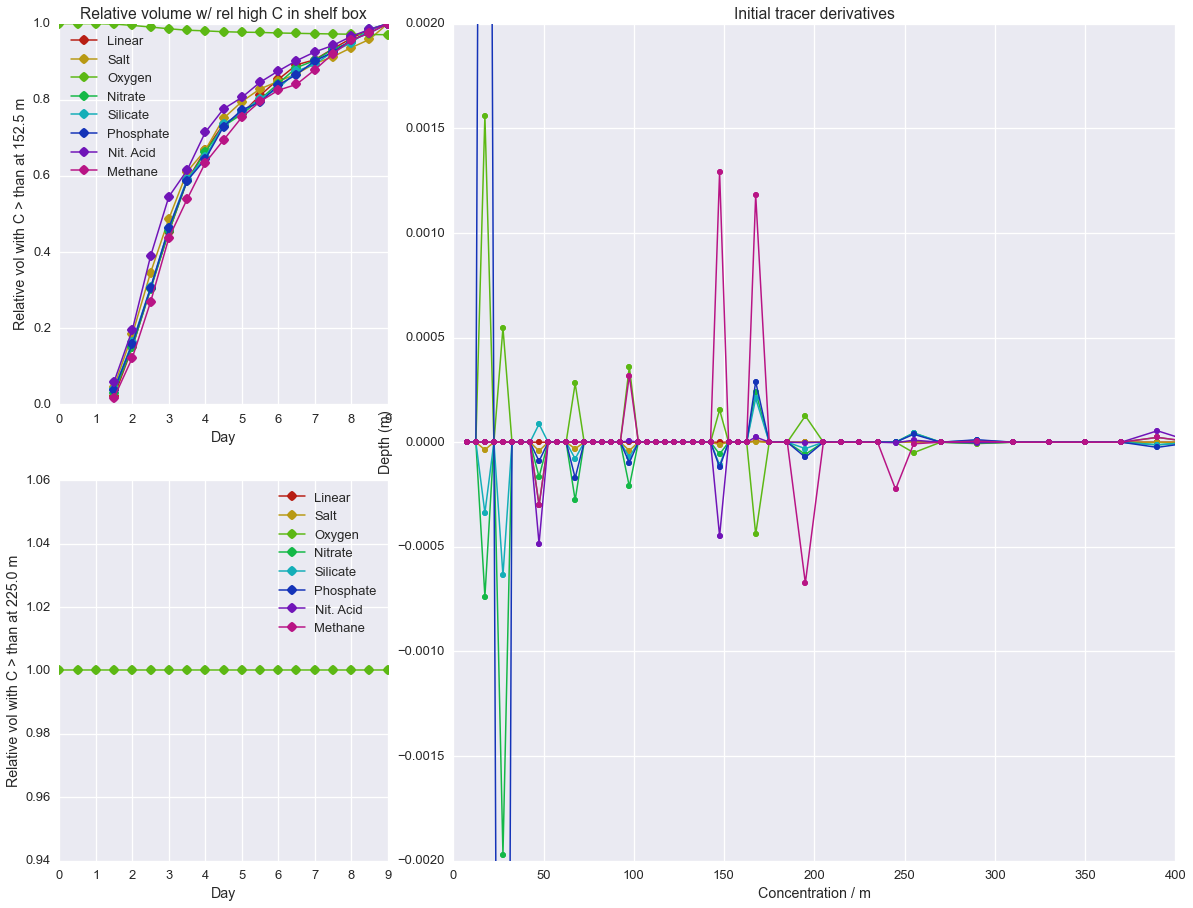

In [18]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

NormDer2Tr1 = ((Tr1[0,2:,50,180]-2.0*Tr1[0,1:-1,50,180]+Tr1[0,:-2,50,180])/np.max(Tr1[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr2 = ((Tr2[0,2:,50,180]-2.0*Tr2[0,1:-1,50,180]+Tr2[0,:-2,50,180])/np.max(Tr2[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr3 = ((Tr3[0,2:,50,180]-2.0*Tr3[0,1:-1,50,180]+Tr3[0,:-2,50,180])/np.max(Tr3[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr4 = ((Tr4[0,2:,50,180]-2.0*Tr4[0,1:-1,50,180]+Tr4[0,:-2,50,180])/np.max(Tr4[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr5 = ((Tr5[0,2:,50,180]-2.0*Tr5[0,1:-1,50,180]+Tr5[0,:-2,50,180])/np.max(Tr5[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr6 = ((Tr6[0,2:,50,180]-2.0*Tr6[0,1:-1,50,180]+Tr6[0,:-2,50,180])/np.max(Tr6[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr7 = ((Tr7[0,2:,50,180]-2.0*Tr7[0,1:-1,50,180]+Tr7[0,:-2,50,180])/np.max(Tr7[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))
NormDer2Tr8 = ((Tr8[0,2:,50,180]-2.0*Tr8[0,1:-1,50,180]+Tr8[0,:-2,50,180])/np.max(Tr8[0,:,50,180]))/(((-rc[2:])-(-rc[1:-1]))*((-rc[1:-1])-(-rc[:-2])))



#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    #ax1 = plt.subplot(2,3,1)
    ax1 = plt.subplot2grid((2,3), (0,0))

    line1 = ax1.plot(times/2.0, WatTr1/np.max(WatTr1),'o-',label='Linear')
    line2 = ax1.plot(times/2.0, WatTr2/np.max(WatTr2),'o-', label='Salt')
    line3 = ax1.plot(times/2.0, WatTr3/np.max(WatTr3),'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, WatTr4/np.max(WatTr4),'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, WatTr5/np.max(WatTr5),'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, WatTr6/np.max(WatTr6),'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, WatTr7/np.max(WatTr7),'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, WatTr8/np.max(WatTr8),'o-', label='Methane')
    
    plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 152.5 m')
    plt.xlabel('Day')


with sns.hls_palette(8, l=.4, s=.8):
    #ax4 = plt.subplot(2,3,4)
    ax4 = plt.subplot2grid((2,3), (1,0))
    line1 = ax4.plot(times/2.0, WatTr1d/np.max(WatTr1d),'o-',label='Linear')
    line2 = ax4.plot(times/2.0, WatTr2d/np.max(WatTr2d),'o-', label='Salt')
    line3 = ax4.plot(times/2.0, WatTr3d/np.max(WatTr3d),'o-', label='Oxygen')
    line4 = ax4.plot(times/2.0, WatTr4d/np.max(WatTr4d),'o-', label='Nitrate')
    line5 = ax4.plot(times/2.0, WatTr5d/np.max(WatTr5d),'o-', label='Silicate')
    line6 = ax4.plot(times/2.0, WatTr6d/np.max(WatTr6d),'o-', label='Phosphate')
    line7 = ax4.plot(times/2.0, WatTr7d/np.max(WatTr7d),'o-', label='Nit. Acid')
    line8 = ax4.plot(times/2.0, WatTr8d/np.max(WatTr8d),'o-', label='Methane')
    
    #plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 225.0 m')
    plt.xlabel('Day')

with sns.hls_palette(8, l=.4, s=.8):
    #ax5 = plt.subplot(2,3,(5,6))
    ax5 = plt.subplot2grid((2,3), (0,1), colspan=2,rowspan=2)
    
    line1 = ax5.plot(-rc[1:-1],NormDer2Tr1,'o-',markersize = 6, label='Linear')
    line2 = ax5.plot(-rc[1:-1],NormDer2Tr2,'o-',markersize = 6, label='Salt')
    line3 = ax5.plot(-rc[1:-1],NormDer2Tr3,'o-',markersize = 6, label='Oxygen')
    line4 = ax5.plot(-rc[1:-1],NormDer2Tr4,'o-',markersize = 6, label='Nitrate')
    line5 = ax5.plot(-rc[1:-1],NormDer2Tr5,'o-',markersize = 6, label='Silicate')
    line6 = ax5.plot(-rc[1:-1],NormDer2Tr6,'o-',markersize = 6, label='Phosphate')
    line7 = ax5.plot(-rc[1:-1],NormDer2Tr7,'o-',markersize = 6, label='Nit. Acid')
    line8 = ax5.plot(-rc[1:-1],NormDer2Tr8,'o-',markersize = 6, label='Methane')
    
     
    ax5.set_xlim(0,400)
    ax5.set_ylim(-0.002,0.002)
    
    plt.title('Initial tracer derivatives')
    #plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    #plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('Depth (m)')
    plt.xlabel('Concentration / m')
    
    
#plt.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
#handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, labels,loc=0)

handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


The second derivative looks too noisy. Let's look at average derivative under shelfbreak over average derivative over shelf break

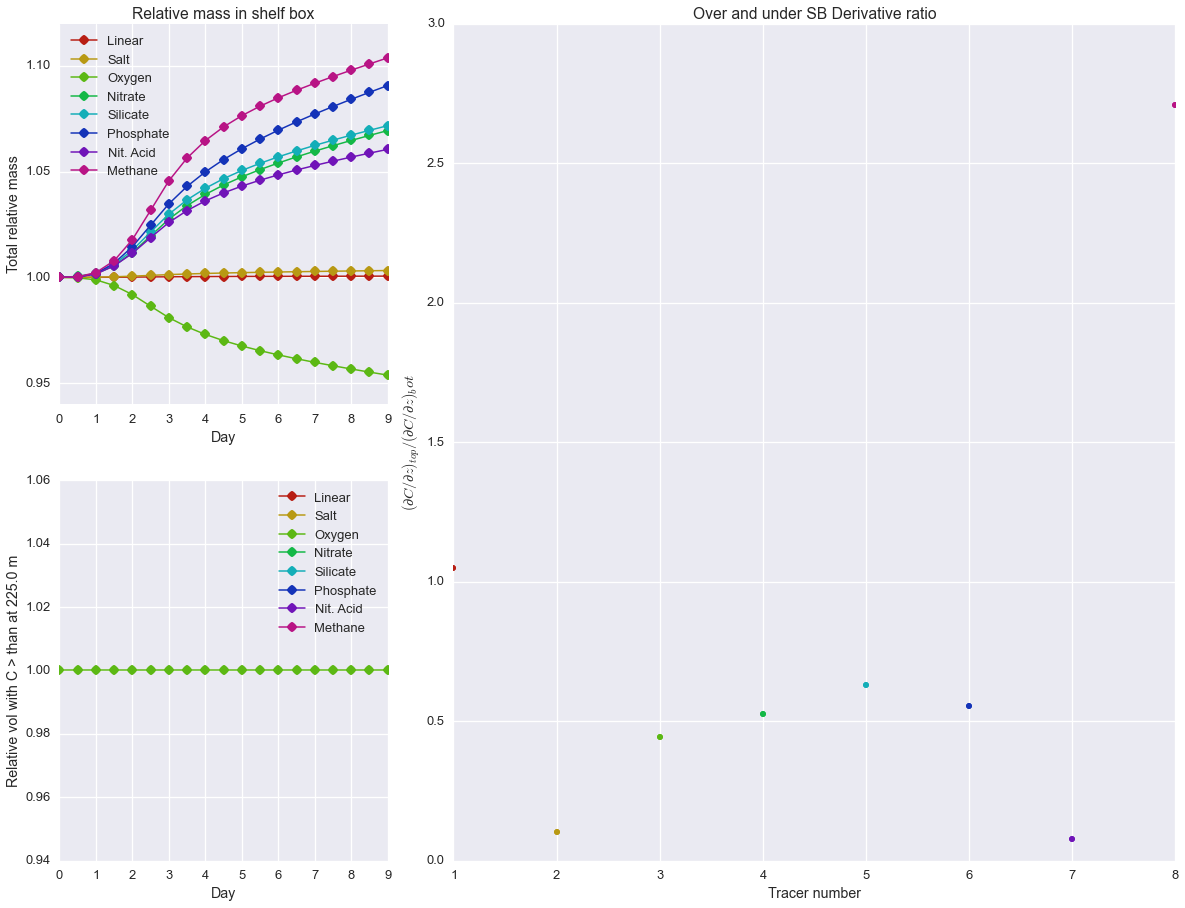

In [19]:
fig45=plt.figure(figsize=(20,15))
sns.set(context='talk', style='darkgrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

NormDerTr1 = ((Tr1[0,2:,50,180]-Tr1[0,:-2,50,180])/np.max(Tr1[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr2 = ((Tr2[0,2:,50,180]-Tr2[0,:-2,50,180])/np.max(Tr2[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr3 = ((Tr3[0,2:,50,180]-Tr3[0,:-2,50,180])/np.max(Tr3[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr4 = ((Tr4[0,2:,50,180]-Tr4[0,:-2,50,180])/np.max(Tr4[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr5 = ((Tr5[0,2:,50,180]-Tr5[0,:-2,50,180])/np.max(Tr5[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr6 = ((Tr6[0,2:,50,180]-Tr6[0,:-2,50,180])/np.max(Tr6[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr7 = ((Tr7[0,2:,50,180]-Tr7[0,:-2,50,180])/np.max(Tr7[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))
NormDerTr8 = ((Tr8[0,2:,50,180]-Tr8[0,:-2,50,180])/np.max(Tr8[0,:,50,180])) /((-rc[2:])-(-rc[:-2]))


#with sns.color_palette('YlOrRd_r',8):
with sns.hls_palette(8, l=.4, s=.8):    
    #ax1 = plt.subplot(2,3,1)
    ax1 = plt.subplot2grid((2,3), (0,0))

    line1 = ax1.plot(times/2.0, TrMassTr1/TrMassTr1[0],'o-', label='Linear')
    line2 = ax1.plot(times/2.0, TrMassTr2/TrMassTr2[0],'o-', label='Salt')
    line3 = ax1.plot(times/2.0, TrMassTr3/TrMassTr3[0],'o-', label='Oxygen')
    line4 = ax1.plot(times/2.0, TrMassTr4/TrMassTr4[0],'o-', label='Nitrate')
    line5 = ax1.plot(times/2.0, TrMassTr5/TrMassTr5[0],'o-', label='Silicate')
    line6 = ax1.plot(times/2.0, TrMassTr6/TrMassTr6[0],'o-', label='Phosphate')
    line7 = ax1.plot(times/2.0, TrMassTr7/TrMassTr7[0],'o-', label='Nit. Acid')
    line8 = ax1.plot(times/2.0, TrMassTr8/TrMassTr8[0],'o-', label='Methane')

    plt.title('Relative mass in shelf box')
    plt.ylabel('Total relative mass')
    plt.xlabel('Day')


with sns.hls_palette(8, l=.4, s=.8):
    #ax4 = plt.subplot(2,3,4)
    ax4 = plt.subplot2grid((2,3), (1,0))
    line1 = ax4.plot(times/2.0, WatTr1d/np.max(WatTr1d),'o-',label='Linear')
    line2 = ax4.plot(times/2.0, WatTr2d/np.max(WatTr2d),'o-', label='Salt')
    line3 = ax4.plot(times/2.0, WatTr3d/np.max(WatTr3d),'o-', label='Oxygen')
    line4 = ax4.plot(times/2.0, WatTr4d/np.max(WatTr4d),'o-', label='Nitrate')
    line5 = ax4.plot(times/2.0, WatTr5d/np.max(WatTr5d),'o-', label='Silicate')
    line6 = ax4.plot(times/2.0, WatTr6d/np.max(WatTr6d),'o-', label='Phosphate')
    line7 = ax4.plot(times/2.0, WatTr7d/np.max(WatTr7d),'o-', label='Nit. Acid')
    line8 = ax4.plot(times/2.0, WatTr8d/np.max(WatTr8d),'o-', label='Methane')
    
    #plt.title('Relative volume w/ rel high C in shelf box')
    plt.ylabel('Relative vol with C > than at 225.0 m')
    plt.xlabel('Day')

with sns.hls_palette(8, l=.4, s=.8):
    #ax5 = plt.subplot(2,3,(5,6))
    ax5 = plt.subplot2grid((2,3), (0,1), colspan=2,rowspan=2)
    
    line1 = ax5.plot(1,1./(np.mean(NormDerTr1[10:29])/(np.mean(NormDerTr1[29:43]))),'o',markersize = 6, label='Linear')
    line2 = ax5.plot(2,1./(np.mean(NormDerTr2[10:29])/(np.mean(NormDerTr2[29:43]))),'o',markersize = 6, label='Salt')
    line3 = ax5.plot(3,1./(np.mean(NormDerTr3[10:29])/(np.mean(NormDerTr3[29:43]))),'o',markersize = 6, label='Oxygen')
    line4 = ax5.plot(4,1./(np.mean(NormDerTr4[10:29])/(np.mean(NormDerTr4[29:43]))),'o',markersize = 6, label='Nitrate')
    line5 = ax5.plot(5,1./(np.mean(NormDerTr5[10:29])/(np.mean(NormDerTr5[29:43]))),'o',markersize = 6, label='Silicate')
    line6 = ax5.plot(6,1./(np.mean(NormDerTr6[10:29])/(np.mean(NormDerTr6[29:43]))),'o',markersize = 6, label='Phosphate')
    line7 = ax5.plot(7,1./(np.mean(NormDerTr7[10:29])/(np.mean(NormDerTr7[29:43]))),'o',markersize = 6, label='Nit. Acid')
    line8 = ax5.plot(8,1./(np.mean(NormDerTr8[10:29])/(np.mean(NormDerTr8[29:43]))),'o',markersize = 6, label='Methane')
    
     
    #ax5.set_xlim(0,400)
    #ax5.set_ylim(-0.002,0.002)
    
    plt.title('Over and under SB Derivative ratio')
    #plt.axhline(y=-150,linewidth=1, color='k', linestyle='--')
    #plt.axhline(y=-225,linewidth=1, color='k', linestyle='-')
    
    plt.ylabel('$(\partial{C}/\partial{z})_{top}/(\partial{C}/\partial{z})_bot$')
    plt.xlabel('Tracer number')
    
    
#plt.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
#handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles, labels,loc=0)

handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels,loc=0)



#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')

        
        


In [37]:
print(WatTr1)
print(WatTr2)
print(WatTr3)
print(WatTr4)
print(WatTr5)
print(WatTr6)
print(WatTr7)
print(WatTr8)

[-- -- -- 157951298.58252147 1122711263.4200535 2288641645.0895834
 3401203832.733767 4421941541.833515 5015899067.988339 5532803460.66979
 5743982555.2475395 6103596038.603717 6419168412.482798 6707540739.473951
 6808797947.47673 7026749674.823505 7230693327.951454 7406356709.928196
 7521299534.972351]
[-- -- -- 289481452.6234512 1147187551.3014512 2159294803.462012
 3040975179.307279 3813127652.000657 4169380501.6821365 4690801869.650136
 4964554888.256971 5173720318.582285 5297922756.896402 5418540192.014305
 5589692931.359404 5702329443.459753 5849868362.951458 5986211131.7698555
 6243998190.940744]
[253568477823.74634 253568477823.74634 253568477823.74634 253305432275.5772
 252428171781.65866 251338624371.28564 250190962258.73956 249234710272.3564
 248783143919.91998 248217385903.67603 247914784994.0296 247768868163.5589
 247383827952.0891 247157484184.6111 246928201952.87085 246735951188.86786
 246554226982.07202 246398133049.8515 246204839813.38074]
[-- -- -- 224902322.11420524 